In [1]:
%matplotlib inline

import json
import glob
import re
import itertools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

mpl.rc('font', family='Arial', size=12)

In [2]:
with open('../../pair_counts.json') as f:
    total_read_counts = pd.Series({k: v/2e6 for k,v in json.load(f).items()})

In [3]:
with open('../../mean_spikein_counts.json') as f:
    spike_counts = pd.Series(json.load(f))

In [4]:
peak_locations = pd.read_csv('../../peak_calls/combined_bam_peaks/gl3_3_vs_input_peaks.broadPeak', 
                             sep = '\t', names = ('chr', 'start', 'end'), usecols = ('chr', 'start', 'end'))


In [5]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

In [6]:
peak_locations['ucsc_index'] = ucsc_index(peak_locations)

# Load raw count data over peaks

In [7]:
count_files = glob.glob('../../count_statistics/new_macs_calls/gl3/*.cov')

In [8]:
bed_names = ['chr', 'start', 'end']

count_data_plus = {}
count_data_minus = {}

for f in count_files:
    if '.p.cov' in f:
        sample_name = re.findall('/([^/]+)\.[pm]\.cov', f)[0]
        
        plus_strand_values = pd.read_csv(f, sep='\t', names = bed_names + [sample_name])
        plus_strand_values.set_index(ucsc_index(plus_strand_values), inplace=True)
        minus_strand_values =  pd.read_csv(f.replace('.p.cov', '.m.cov'), sep='\t', names = bed_names + [sample_name])
        minus_strand_values.set_index(ucsc_index(minus_strand_values), inplace=True)
        count_data_plus[sample_name] = plus_strand_values[sample_name]
        count_data_minus[sample_name] = minus_strand_values[sample_name]

In [9]:
count_data_minus = pd.DataFrame(count_data_minus)
count_data_plus = pd.DataFrame(count_data_plus)

In [10]:
count_data_minus = count_data_minus[count_data_minus.index.isin(peak_locations.ucsc_index)]
count_data_plus = count_data_plus[count_data_plus.index.isin(peak_locations.ucsc_index)]

In [11]:
len(count_data_plus), len(peak_locations)

(65541, 65541)

In [12]:
ip_cols = list('_'.join(i) for i in itertools.product(['dmso', 'drb', 'gl3'], ['2', '3']))
rh_cols = [i + '_rh' for i in ['drb', 'gl3']]

# Find areas of high strand bias

In [13]:
strand_bias = ((count_data_plus - count_data_minus)/(count_data_plus + count_data_minus))[ip_cols]

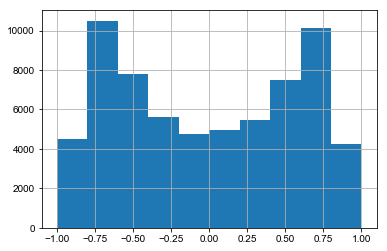

In [14]:
strand_bias.mean(axis=1).hist()

In [15]:
has_bias = strand_bias.mean(axis=1).abs() > 1/3

In [16]:
count_data_both = count_data_minus + count_data_plus

# Find RNase H sensitive areas 

In [17]:
count_data_both.head()

,aqr_1,aqr_2,aqr_2in,aqr_3,aqr_in,aqr_rh,dmso_1,dmso_2,dmso_3,dmso_in,...,gl3_1,gl3_2,gl3_3,gl3_in,gl3_rh,mcm_1,mcm_2,mcm_3,mcm_in,mcm_rh
chr,,,,,,,,,,,,,,,,,,,,,
chr1:10019-10322,347,92,0,103,48,73,263,68,73,76,...,166,77,66,51,197,77,107,76,43,77
chr1:81870-82280,15,18,0,22,10,19,13,23,21,14,...,11,26,26,9,18,21,26,25,13,23
chr1:83829-84115,40,18,0,27,6,40,45,22,17,20,...,46,29,17,13,46,32,35,21,19,36
chr1:629300-631406,1387,864,0,1019,480,1801,1198,883,833,509,...,1564,937,783,436,2104,721,960,944,658,2037
chr1:633861-634155,1384,972,0,1329,365,2830,1483,983,941,390,...,2108,1052,1124,315,3216,902,1175,1150,479,2891


In [18]:
count_data_both.loc['chr5:37322709-37343130', :].div(total_read_counts)

aqr_1      28.291091
aqr_2      31.725255
aqr_2in          NaN
aqr_3      33.540910
aqr_in     16.868805
aqr_rh     16.205527
dmso_1     23.043815
dmso_2     31.248116
dmso_3     31.151214
dmso_in    17.011010
drb_1      12.694132
drb_2      14.202515
drb_3      16.085583
drb_in     15.346044
drb_rh     12.872676
gl3_1      19.418179
gl3_2      29.559124
gl3_3      35.731838
gl3_in     16.642836
gl3_rh     17.373463
mcm_1      25.213024
mcm_2      26.041064
mcm_3      27.832744
mcm_in     15.339931
mcm_rh     18.145239
dtype: float64

In [19]:
mean_rh_rpm = (count_data_both[rh_cols] / total_read_counts[rh_cols]).mean(axis=1)

In [20]:
mean_ip_rpm = (count_data_both[ip_cols] / total_read_counts[ip_cols]).mean(axis=1)

In [21]:
mean_ip_rpm['chr5:37322709-37343130']

26.329731919659114

In [22]:
mean_rh_rpm['chr5:37322709-37343130']

15.12306953315412

In [23]:
ratio = np.log2(mean_ip_rpm / mean_rh_rpm)

(array([2549., 2716., 2904., 3061., 3167., 3200., 3288., 3205., 3081.,
        3003., 2691., 2574., 2341., 2018., 1859., 1525., 1322., 1092.,
         903.,  668.,  557.,  432.,  326.,  292.,  207.,  171.,  139.,
         130.,   93.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9]),
 <a list of 29 Patch objects>)

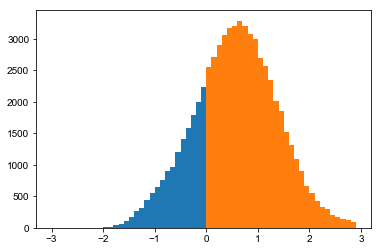

In [24]:
fig, ax = plt.subplots()

ax.hist(ratio[np.isfinite(ratio)], bins = np.arange(-3,0.1, 0.1))
ax.hist(ratio[np.isfinite(ratio)], bins = np.arange(0,3, 0.1))

In [25]:
rh_sensitive = ((mean_ip_rpm/2) > mean_rh_rpm)

In [26]:
rh_sensitivity = ((mean_ip_rpm/2) / mean_rh_rpm)

In [27]:
rh_sensitivity['chr5:37322709-37343130']

0.8705154685011786

In [28]:
rh_sensitive

chr
chr1:10019-10322          False
chr1:81870-82280          False
chr1:83829-84115          False
chr1:629300-631406        False
chr1:633861-634155        False
chr1:653619-653926        False
chr1:669251-669639        False
chr1:788757-791618        False
chr1:821209-823556        False
chr1:839081-839371        False
chr1:911495-913101        False
chr1:914852-915509        False
chr1:918997-921001        False
chr1:943174-946191        False
chr1:957682-958004        False
chr1:974916-975262        False
chr1:999573-1001553       False
chr1:1078866-1081543      False
chr1:1089396-1098039      False
chr1:1100622-1101153      False
chr1:1216474-1216808      False
chr1:1219011-1219640      False
chr1:1234429-1235539      False
chr1:1237004-1238102      False
chr1:1258341-1262816      False
chr1:1269876-1271328      False
chr1:1301032-1301727      False
chr1:1303498-1304152      False
chr1:1309079-1313004      False
chr1:1326597-1336413       True
                          ...  
chrY

In [29]:
len(mean_ip_rpm)

65541

In [30]:
(has_bias & rh_sensitive).sum()

16895

# Output bed file

In [31]:
coords = count_data_both.index.str.extract('(.*):(\d+)-(\d+)', expand=True).rename(columns={0:'chr', 1:'start', 2:'end'})
coords = coords.set_index(ucsc_index(coords))

In [32]:
coords['strand'] = np.nan
coords.loc[~has_bias, 'strand'] = '.'
coords.loc[(strand_bias.mean(axis=1) > 0.5), 'strand'] = '-' # Will annotate according to direction of "transcription" implied by R-loop
coords.loc[(strand_bias.mean(axis=1) < 0.5), 'strand'] = '+'

coords['name'] = '.'
coords['value'] = '.'

In [38]:
def genome_length(subset):
    return pd.to_numeric(coords[subset].end) - pd.to_numeric(coords[subset].start)

In [47]:
!echo $(whoami)@$HOSTNAME:$(pwd)

cimprich@cimprichserver.stanford.edu:/Volumes/Pegasus/DRIP_spike_in/qdrip/notebooks/read_counts


In [44]:
len(coords), has_bias.sum(), rh_sensitive.sum(), (has_bias & rh_sensitive).sum()

(65541, 48775, 19912, 16895)

In [42]:
 genome_length(has_bias).sum()/1e6, genome_length(rh_sensitive).sum()/1e6, genome_length(has_bias & rh_sensitive).sum()/1e6

(312.443869, 209.492574, 191.151317)

In [33]:
subset = coords.loc[(has_bias & rh_sensitive), ]

In [106]:
(pd.to_numeric(coords.end) - pd.to_numeric(coords.start)).sum()

363239284

In [34]:
(pd.to_numeric(subset.end) - pd.to_numeric(subset.start)).sum()

191151317

In [35]:
191151317 /1e6

191.151317

In [36]:
(coords
 .loc[(has_bias & rh_sensitive),'chr start end name value strand'.split()]
 .sort_values(['chr', 'start', 'end'])
 .to_csv('../../peak_calls/combined_bam_peaks/gl3_broad_annotated.bed',
          index=False, header=False, sep='\t')
)

In [37]:
(coords
 .loc[(rh_sensitive),'chr start end name value strand'.split()]
 .sort_values(['chr', 'start', 'end'])
 .to_csv('../../peak_calls/combined_bam_peaks/gl3_broad_annotated_nofilter_strand_bias.bed',
          index=False, header=False, sep='\t')
)

In [38]:
(coords
 .loc[(has_bias & ~rh_sensitive),'chr start end name value strand'.split()]
 .sort_values(['chr', 'start', 'end'])
 .to_csv('../../peak_calls/combined_bam_peaks/gl3_broad_annotated_rh_insensitive.bed',
          index=False, header=False, sep='\t')
)

In [39]:
(coords
 ['chr start end name value strand'.split()]
 .sort_values(['chr', 'start', 'end'])
 .to_csv('../../peak_calls/combined_bam_peaks/gl3_broad_annotated_all_peaks.bed',
          index=False, header=False, sep='\t')
)

# Histogram of peak lengths

In [49]:
coords.head()

,chr,start,end,strand,name,value
chr,,,,,,
chr1:10019-10322,chr1,10019,10322,+,.,.
chr1:81870-82280,chr1,81870,82280,+,.,.
chr1:83829-84115,chr1,83829,84115,+,.,.
chr1:629300-631406,chr1,629300,631406,+,.,.
chr1:633861-634155,chr1,633861,634155,+,.,.


In [50]:
coords.start = pd.to_numeric(coords.start)
coords.end = pd.to_numeric(coords.end)

In [51]:
coords['length'] = (coords.end - coords.start)

In [52]:
coords.length.mean()

5542.168779847729

In [53]:
within_quantiles = (coords.length < coords.length.quantile(0.95)) & (coords.length >= coords.length.quantile(0.05))

In [54]:
within_quantiles.mean()

0.9006423460124197

In [55]:
coords['rh_sensitive'] = rh_sensitive
coords['has_bias'] = has_bias
coords['within_quantiles'] = within_quantiles
coords['filtered'] = has_bias & rh_sensitive

In [56]:
categories = coords.groupby(['filtered', 'within_quantiles']).size().unstack()

In [57]:
coords.filtered.mean()

0.2577775743427778

In [58]:
coords.filtered.sum()

16895

In [59]:
categories.head()

within_quantiles,False,True
filtered,,
False,3643,45003
True,2869,14026


In [60]:
categories.iloc[1,1] / categories.iloc[0,1]

0.3116681110148212

In [61]:
coords[coords.filtered].length.median()

3739.0

In [68]:
coords[coords.filtered].length.quantile(0.25)

1099.0

In [69]:
coords[coords.filtered].length.quantile(0.75)

13901.5

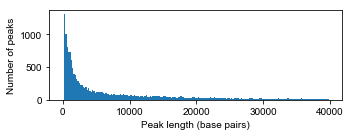

In [65]:
fig, ax = plt.subplots(figsize=(5,2))
(coords[coords.filtered].end - coords[coords.filtered].start).hist(bins = np.arange(0, 40000, 200), ax=ax)
ax.grid(False)
ax.set_ylabel('Number of peaks')
ax.set_xlabel('Peak length (base pairs)')
ax.set_xticks(np.arange(0, 50000, 10000))
fig.tight_layout()
fig.savefig('Peak_size.svg')
fig.savefig('Peak_size.png', dpi=200)

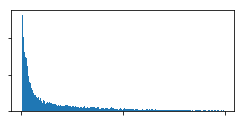

In [107]:
fig, ax = plt.subplots(figsize=(3.5,1.8))
(coords[coords.filtered].end - coords[coords.filtered].start).hist(bins = np.arange(0, 40000, 200), ax=ax)
ax.grid(False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks(np.arange(0, 50000, 20000))
for t in ax.get_xticklabels():
    t.set_visible(False)
for t in ax.get_yticklabels():
    t.set_visible(False)
fig.tight_layout()
fig.savefig('Peak_size_unlabelled.svg')
fig.savefig('Peak_size_unlabelled.png', dpi=200)

# Overlap with gene file

In [40]:
!mkdir ../../peak_calls/combined_bam_peaks/gene_overlap

mkdir: ../../peak_calls/combined_bam_peaks/gene_overlap: File exists


In [41]:
!head ../../peak_calls/combined_bam_peaks/gl3_broad_annotated.bed

chr1	100012840	100014213	.	.	+
chr1	100019476	100022850	.	.	+
chr1	100033590	100040859	.	.	+
chr1	100139451	100152201	.	.	+
chr1	100187056	100195372	.	.	-
chr1	100278113	100279378	.	.	+
chr1	100280521	100280995	.	.	+
chr1	100298480	100299137	.	.	+
chr1	100878009	100890977	.	.	-
chr1	100892070	100894766	.	.	-


In [42]:
!bedtools slop -b 500 -g ../../hg38.chrom.sizes -i /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical.bed > /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_expanded.bed 
!bedtools intersect -wao -b /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_expanded.bed -a ../../peak_calls/combined_bam_peaks/gl3_broad_annotated_nofilter_strand_bias.bed > ../../peak_calls/combined_bam_peaks/gene_overlap/gl3_ovelap.tsv

In [43]:
!head ../../peak_calls/final_peaks/gene_overlap/gl3_ovelap.tsv

chr1	999593	1000012	.	.	-	chr1	998463	1000611	ENST00000304952.10	419
chr1	1329697	1330567	.	.	-	.	-1	-1	.	0
chr1	1330839	1336441	.	.	-	chr1	1330813	1335806	ENST00000339381.5	4967
chr1	1330839	1336441	.	.	-	chr1	1334775	1349612	ENST00000378891.9	1666
chr1	1495885	1496644	.	.	+	chr1	1471268	1496702	ENST00000308647.7	759
chr1	1889699	1891063	.	.	-	chr1	1890970	1893158	ENST00000412228.1	93
chr1	1889699	1891063	.	.	-	chr1	1784784	1891617	ENST00000610897.4	1364
chr1	2185988	2188552	.	.	-	.	-1	-1	.	0
chr1	2228718	2232166	.	.	+	chr1	2228194	2310619	ENST00000378536.4	3448
chr1	2375912	2388528	.	.	-	chr1	2320752	2392207	ENST00000378531.7	12616


In [70]:
overlaps = pd.read_csv('../../peak_calls/combined_bam_peaks/gene_overlap/gl3_ovelap.tsv', 
                       names = 'chr start end name value strand gene_chr gene_start gene_end transcript_id overlap'.split(),
                       usecols = 'chr start end strand transcript_id'.split(), sep='\t'
                      )

gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_GENCODE_v29.tsv', sep='\t',
                        names = 'transcript_id chr strand start end'.split(), usecols = 'transcript_id chr strand start end'.split(),
                        skiprows =1
                       )
overlaps = overlaps.merge(gene_data, on = 'transcript_id', suffixes=['', '_gene'], how = 'left')

In [71]:
overlaps['min_dist_to_start'] = (overlaps[['start', 'end']].subtract(overlaps.start_gene, axis=0)).abs().min(axis=1)
overlaps['min_dist_to_end'] = (overlaps[['start', 'end']].subtract(overlaps.end_gene, axis=0)).abs().min(axis=1)

In [72]:
# Calculate min distance from the ends of each interval to the promoter or terminator of its overlapping gene
overlaps['min_dist_to_prom'] = np.nan
overlaps['min_dist_to_term'] = np.nan

overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_prom'] = overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_start']
overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_term'] = overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_end']

overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_prom'] = overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_end']
overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_term'] = overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_start']

In [73]:
# If the region overlaps the promoter or terminator, set the min distance to 0
overlaps.loc[(overlaps.strand_gene == '+') & 
             (overlaps.start < overlaps.start_gene) & 
             (overlaps.end > overlaps.start_gene), 'min_dist_to_prom'] = 0

overlaps.loc[(overlaps.strand_gene == '-') & 
             (overlaps.start < overlaps.end_gene) & 
             (overlaps.end > overlaps.end_gene), 'min_dist_to_prom'] = 0

overlaps.loc[(overlaps.strand_gene == '-') & 
             (overlaps.start < overlaps.start_gene) & 
             (overlaps.end > overlaps.start_gene), 'min_dist_to_term'] = 0

overlaps.loc[(overlaps.strand_gene == '+') & 
             (overlaps.start < overlaps.end_gene) & 
             (overlaps.end > overlaps.end_gene), 'min_dist_to_term'] = 0

In [74]:
overlaps['ucsc_name'] = ucsc_index(overlaps)

In [75]:
distances_to_ends = (overlaps
                     .groupby('ucsc_name')
                     [['min_dist_to_term', 'min_dist_to_prom']]
                     .min())

In [76]:
terminator_dist = 3000
promoter_dist = 3000

annotations = {}
annotations['promoter_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                                   (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations['terminator_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                     (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations['gene_body'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                              (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations['promoter_and_terminator'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                            (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations['intergenic'] = set(overlaps[overlaps.chr_gene.isnull()].ucsc_name)


In [77]:
peak_percents = {k:len(v)/sum(len(i) for i in annotations.values()) for k, v in annotations.items()}

In [78]:
total_bases_hg38 = 3209286105
bases_per_region = {
    'promoter_alone': 337026562 - 179514614,
    'terminator_alone': 337026562 - 179514614,
    'promoter_and_terminator': 179514614,
    'gene_body': 1406465624
}
genome_percents = {k: v/total_bases_hg38 for k,v in bases_per_region.items()}
genome_percents['intergenic'] = 1 - sum(genome_percents.values())

In [104]:
genome_percents['intergenic'] * total_bases_hg38

1308281971.0

In [105]:
sum(bases_per_region.values())

1901004134

In [79]:
n_peaks = {k: len(v) for k,v in annotations.items()}

In [80]:
n_peaks

{'gene_body': 11541,
 'intergenic': 1409,
 'promoter_alone': 1273,
 'promoter_and_terminator': 3327,
 'terminator_alone': 2362}

In [81]:
expected = {k: int(np.round(v * sum(n_peaks.values()))) for k, v in genome_percents.items()}

In [82]:
pd.Series(n_peaks), pd.Series(expected)

(gene_body                  11541
 intergenic                  1409
 promoter_alone              1273
 promoter_and_terminator     3327
 terminator_alone            2362
 dtype: int64, gene_body                  8726
 intergenic                 8117
 promoter_alone              977
 promoter_and_terminator    1114
 terminator_alone            977
 dtype: int64)

In [83]:
stats.chisquare(f_obs=pd.Series(n_peaks), f_exp=pd.Series(expected))
"""
I went through some pains to get an actual p-value here, as it's 
clearly something so low that Python reduces it to numerical error.
Using Wolfram Alpha, I calculated an "exact" value with the following query:
https://www.wolframalpha.com/input/?i=+GammaRegularized%282%2C+12900.96%2F2%29
Which shows a p-value around 2.5e-2798 (that's not a typo)
"""

'\nI went through some pains to get an actual p-value here, as it\'s \nclearly something so low that Python reduces it to numerical error.\nUsing Wolfram Alpha, I calculated an "exact" value with the following query:\nhttps://www.wolframalpha.com/input/?i=+GammaRegularized%282%2C+12900.96%2F2%29\nWhich shows a p-value around 2.5e-2798 (that\'s not a typo)\n'

In [84]:
percent_data = (pd.DataFrame({
    'Genome': genome_percents,
    'Peaks': peak_percents
})
    .reset_index()
    .melt(id_vars = 'index')
    .rename(columns = {'index': 'Region',
                       'variable': 'Type',
                       'value': 'Percent of regions'
                      }))
                      

In [85]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.579600
6,intergenic,Peaks,0.070761
7,promoter_alone,Peaks,0.063931
8,promoter_and_terminator,Peaks,0.167085
9,terminator_alone,Peaks,0.118622


In [86]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.579600
6,intergenic,Peaks,0.070761
7,promoter_alone,Peaks,0.063931
8,promoter_and_terminator,Peaks,0.167085
9,terminator_alone,Peaks,0.118622


In [87]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.579600
6,intergenic,Peaks,0.070761
7,promoter_alone,Peaks,0.063931
8,promoter_and_terminator,Peaks,0.167085
9,terminator_alone,Peaks,0.118622


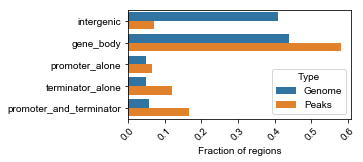

In [88]:
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(
     y = 'Region',
     hue = 'Type',
     order = ['intergenic', 'gene_body', 'promoter_alone', 'terminator_alone', 'promoter_and_terminator'],
     x = 'Percent of regions',
     data = percent_data)
ax.set_xlabel('Fraction of regions')
ax.set_ylabel('')
ticks = ax.xaxis.get_ticklabels()
for t in ticks:
    t.set_rotation(45)
fig.savefig('peak_locations.svg')

In [89]:
genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical.bed',
                    names = ('chr', 'start', 'end', 'name'), sep = '\t'
                   )

In [90]:
genes.head()

,chr,start,end,name
0,chr1,11868,14409,ENST00000456328.2
1,chr1,14403,29570,ENST00000488147.1
2,chr1,17368,17436,ENST00000619216.1
3,chr1,29553,31097,ENST00000473358.1
4,chr1,30365,30503,ENST00000607096.1


In [91]:
genes['length'] = genes.end - genes.start
lengths = (genes.length - 7000)
lengths[lengths < 0] = 0

In [61]:
lengths.sum()

1406465624

In [92]:
overlaps['site_annotation'] = np.nan
overlaps.loc[overlaps.ucsc_name.isin(annotations['promoter_alone']), 'site_annotation'] = 'promoter_alone'
overlaps.loc[overlaps.ucsc_name.isin(annotations['terminator_alone']), 'site_annotation'] = 'terminator_alone'
overlaps.loc[overlaps.ucsc_name.isin(annotations['gene_body']), 'site_annotation'] = 'gene_body'
overlaps.loc[overlaps.ucsc_name.isin(annotations['promoter_and_terminator']), 'site_annotation'] = 'promoter_and_terminator'
overlaps.loc[overlaps.ucsc_name.isin(annotations['intergenic']), 'site_annotation'] = 'intergenic'


In [93]:
coords['ucsc'] = ucsc_index(coords)

In [94]:
coords['site_annotation'] = np.nan
coords.loc[coords.ucsc.isin(annotations['promoter_alone']), 'site_annotation'] = 'promoter_alone'
coords.loc[coords.ucsc.isin(annotations['terminator_alone']), 'site_annotation'] = 'terminator_alone'
coords.loc[coords.ucsc.isin(annotations['gene_body']), 'site_annotation'] = 'gene_body'
coords.loc[coords.ucsc.isin(annotations['promoter_and_terminator']), 'site_annotation'] = 'promoter_and_terminator'
coords.loc[coords.ucsc.isin(annotations['intergenic']), 'site_annotation'] = 'intergenic'

In [65]:
filtered = coords[(rh_sensitive & has_bias)]

In [66]:
filtered.to_csv('../../peak_calls/combined_bam_peaks/gl3_consensus_annotated.tsv')

# Redo with full gene set

In [67]:
!bedtools intersect -wao -b /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_expanded.bed -a ../../peak_calls/combined_bam_peaks/gl3_broad_annotated_all_peaks.bed > ../../peak_calls/combined_bam_peaks/gene_overlap/gl3_overlap_all.tsv


In [95]:
overlaps_all = pd.read_csv('../../peak_calls/combined_bam_peaks/gene_overlap/gl3_overlap_all.tsv', 
                           names = 'chr start end name value strand gene_chr gene_start gene_end transcript_id overlap'.split(),
                           usecols = 'chr start end strand transcript_id'.split(), sep='\t'
                          )
overlaps_all = overlaps_all.merge(gene_data, on = 'transcript_id', suffixes=['', '_gene'], how = 'left')


In [96]:

overlaps_all['min_dist_to_start'] = (overlaps_all[['start', 'end']].subtract(overlaps_all.start_gene, axis=0)).abs().min(axis=1)
overlaps_all['min_dist_to_end'] = (overlaps_all[['start', 'end']].subtract(overlaps_all.end_gene, axis=0)).abs().min(axis=1)

# Calculate min distance from the ends of each interval to the promoter or terminator of its overlapping gene
overlaps_all['min_dist_to_prom'] = np.nan
overlaps_all['min_dist_to_term'] = np.nan

overlaps_all.loc[overlaps_all.strand_gene == '+', 'min_dist_to_prom'] = overlaps_all.loc[overlaps_all.strand_gene == '+', 'min_dist_to_start']
overlaps_all.loc[overlaps_all.strand_gene == '+', 'min_dist_to_term'] = overlaps_all.loc[overlaps_all.strand_gene == '+', 'min_dist_to_end']

overlaps_all.loc[overlaps_all.strand_gene == '-', 'min_dist_to_prom'] = overlaps_all.loc[overlaps_all.strand_gene == '-', 'min_dist_to_end']
overlaps_all.loc[overlaps_all.strand_gene == '-', 'min_dist_to_term'] = overlaps_all.loc[overlaps_all.strand_gene == '-', 'min_dist_to_start']

# If the region overlaps_all the promoter or terminator, set the min distance to 0
overlaps_all.loc[(overlaps_all.strand_gene == '+') & 
             (overlaps_all.start < overlaps_all.start_gene) & 
             (overlaps_all.end > overlaps_all.start_gene), 'min_dist_to_prom'] = 0

overlaps_all.loc[(overlaps_all.strand_gene == '-') & 
             (overlaps_all.start < overlaps_all.end_gene) & 
             (overlaps_all.end > overlaps_all.end_gene), 'min_dist_to_prom'] = 0

overlaps_all.loc[(overlaps_all.strand_gene == '-') & 
             (overlaps_all.start < overlaps_all.start_gene) & 
             (overlaps_all.end > overlaps_all.start_gene), 'min_dist_to_term'] = 0

overlaps_all.loc[(overlaps_all.strand_gene == '+') & 
             (overlaps_all.start < overlaps_all.end_gene) & 
             (overlaps_all.end > overlaps_all.end_gene), 'min_dist_to_term'] = 0

overlaps_all['ucsc_name'] = ucsc_index(overlaps_all)

distances_to_ends = (overlaps_all
                     .groupby('ucsc_name')
                     [['min_dist_to_term', 'min_dist_to_prom']]
                     .min())

terminator_dist = 3000
promoter_dist = 3000

annotations_all = {}
annotations_all['promoter_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                                   (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations_all['terminator_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                     (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations_all['gene_body'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                              (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations_all['promoter_and_terminator'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                            (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations_all['intergenic'] = set(overlaps_all[overlaps_all.chr_gene.isnull()].ucsc_name)

In [101]:
(overlaps_all[overlaps_all.chr_gene.isnull()].end - overlaps_all[overlaps_all.chr_gene.isnull()].start).sum()

15228779

In [102]:
15228779 / 1e6

15.228779

In [97]:
peak_percents_all = {k:len(v)/sum(len(i) for i in annotations_all.values()) for k, v in annotations_all.items()}

In [98]:
percent_data_all = (pd.DataFrame({
    'Genome': genome_percents,
    'Peaks': peak_percents_all
})
    .reset_index()
    .melt(id_vars = 'index')
    .rename(columns = {'index': 'Region',
                       'variable': 'Type',
                       'value': 'Percent of regions'
                      }))
                      

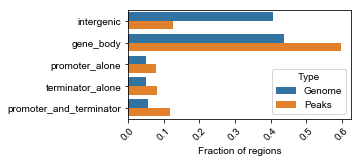

In [99]:
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(
     y = 'Region',
     hue = 'Type',
     order = ['intergenic', 'gene_body', 'promoter_alone', 'terminator_alone', 'promoter_and_terminator'],
     x = 'Percent of regions',
     data = percent_data_all)
ax.set_xlabel('Fraction of regions')
ax.set_ylabel('')
ticks = ax.xaxis.get_ticklabels()
for t in ticks:
    t.set_rotation(45)

In [71]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.567268
6,intergenic,Peaks,0.068186
7,promoter_alone,Peaks,0.068127
8,promoter_and_terminator,Peaks,0.171589
9,terminator_alone,Peaks,0.124830


In [72]:
percent_data_all

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.596360
6,intergenic,Peaks,0.125570
7,promoter_alone,Peaks,0.079584
8,promoter_and_terminator,Peaks,0.117041
9,terminator_alone,Peaks,0.081445


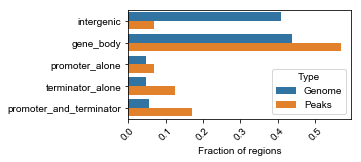

In [70]:
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(
     y = 'Region',
     hue = 'Type',
     order = ['intergenic', 'gene_body', 'promoter_alone', 'terminator_alone', 'promoter_and_terminator'],
     x = 'Percent of regions',
     data = percent_data)
ax.set_xlabel('Fraction of regions')
ax.set_ylabel('')
ticks = ax.xaxis.get_ticklabels()
for t in ticks:
    t.set_rotation(45)
fig.savefig('peak_locations.svg')